# Load Libraries

In [1]:
import numpy as np  # linear algebra

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

from keras.utils import plot_model
from IPython.display import Image 

import timeit


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

# Load Data

In [2]:
#fileToRead = '../Data/OilRefineryData.xlsx'
fileToRead = '../Data/WindPowerForecasting.xlsx'
rawData = pd.read_excel(fileToRead)
#Display data info

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
rawData.head(10)

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,20120101 1:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,20120101 2:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,20120101 3:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,20120101 4:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,20120101 5:00,0.156940,2.245898,0.389576,2.957678,0.332701
5,20120101 6:00,0.168781,1.986038,0.796304,2.655406,0.882648
6,20120101 7:00,0.114745,1.319787,1.440681,1.946708,1.941323
7,20120101 8:00,0.085424,-0.122061,2.358907,-0.235427,4.323885
8,20120101 9:00,0.153181,-1.380191,2.903624,-3.048145,6.041520
9,20120101 10:00,0.139273,-1.710881,2.013933,-4.213648,4.877628


# Check for Missing Data

In [4]:
rawData.isnull().sum()

TIMESTAMP     0
TARGETVAR    35
U10           0
V10           0
U100          0
V100          0
dtype: int64

# Deal with Missing Data

It is clear that here are many missing values in the data. The solution is to fill the N/A values with the folowing:
1. Mean of each feature for numerical features.

This step ca be implemented using the command:

>pandas.DataFrame.fillna(DataFrame.mean(),inplace=True)

2. Fill N/A with neighbor values for string features. 

This is achieved by the following command:

>pandas.DataFrame.fillna(method='bfill')


In [5]:
fixedRawData = rawData
for col in rawData.columns:
    #print('Filling column ', col)
    if(rawData[col].dtype == 'object'):
        fixedRawData[col] = rawData[col].fillna(method='bfill')
    else:
        fixedRawData[col] = rawData[col].fillna(fixedRawData[col].mean())

In [6]:
print('Missing Data:')
fixedRawData.isnull().sum()

Missing Data:


TIMESTAMP    0
TARGETVAR    0
U10          0
V10          0
U100         0
V100         0
dtype: int64

# Normalization

In [11]:
NormOrScale = 0
if(NormOrScale == 0):
    normalizedData=(fixedRawData-fixedRawData.mean())/fixedRawData.std()
elif(NormOrScale == 1):
    normalizedData=(fixedRawData-fixedRawData.min())/(fixedRawData.max()-fixedRawData.min())


In [12]:
del normalizedData['TIMESTAMP']
featureNames = normalizedData.columns
normalizedData

,TARGETVAR,U10,U100,V10,V100
0,-1.047630e+00,0.465135,0.303671,-0.832710,-0.618776
1,-8.579996e-01,0.620467,0.416316,-0.529624,-0.379867
2,-6.667253e-01,0.679344,0.454661,-0.195909,-0.131143
3,-4.770848e-01,0.595357,0.385933,0.036584,0.039598
4,-5.053360e-01,0.512583,0.325564,0.219194,0.176472
...,...,...,...,...,...
16795,-1.534514e-15,-1.102634,-1.341183,-0.789087,-1.330735
16796,-1.534514e-15,-1.248584,-1.306854,-1.113995,-1.354609
16797,-1.534514e-15,-1.257667,-1.188111,-1.285914,-1.212264
16798,-1.534514e-15,-1.124088,-1.008011,-1.480033,-1.255134


# Reframe Data

For prediction of timeseries data, the model has to estimate features from the previous values. So, if the desired output is $x(t)$, the input feature should be $x(t-1)$. 

Series to supervised function is designed to take samples of $\{t-n,t-n-1, ..., t-1\}$ as input for the machine learning. The output will be samples at $\{t, t+1, ..., t+n\}$. 

For the current application, the COVID-19 data are sampled daily and hence the input is previous day and the output is the current day. 

## Reframe Data Function

In [13]:
# ## Splitting Train and Test data

# ## Resample the data
def Reframe(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    returnedData = pd.concat(cols, axis=1)
    returnedData.columns = names
    # drop rows with NaN values
    if dropnan:
        returnedData.dropna(inplace=True)
    return returnedData


# Application of Reframe Data
## Get Numerical Data

In [14]:
#cleanData2.head()
values = normalizedData.values

In [15]:
normalizedData.head()

,TARGETVAR,U10,U100,V10,V100
0,-1.047630,0.465135,0.303671,-0.832710,-0.618776
1,-0.858000,0.620467,0.416316,-0.529624,-0.379867
2,-0.666725,0.679344,0.454661,-0.195909,-0.131143
3,-0.477085,0.595357,0.385933,0.036584,0.039598
4,-0.505336,0.512583,0.325564,0.219194,0.176472


In [16]:
values.shape

(16800, 5)

## ِApply Reframe Data
Apply reframe function on the values of Data

In [17]:
# frame as supervised learning
reframed = Reframe(values, 1, 1)
reframed.head(20)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,-1.047630,0.465135,0.303671,-0.832710,-0.618776,-0.858000,0.620467,0.416316,-0.529624,-0.379867
2,-0.858000,0.620467,0.416316,-0.529624,-0.379867,-0.666725,0.679344,0.454661,-0.195909,-0.131143
3,-0.666725,0.679344,0.454661,-0.195909,-0.131143,-0.477085,0.595357,0.385933,0.036584,0.039598
4,-0.477085,0.595357,0.385933,0.036584,0.039598,-0.505336,0.512583,0.325564,0.219194,0.176472
5,-0.505336,0.512583,0.325564,0.219194,0.176472,-0.464420,0.410933,0.254713,0.358485,0.285841
6,-0.464420,0.410933,0.254713,0.358485,0.285841,-0.651138,0.150314,0.088598,0.579163,0.496383
7,-0.651138,0.150314,0.088598,0.579163,0.496383,-0.752453,-0.413695,-0.422882,0.893626,0.970209
8,-0.752453,-0.413695,-0.422882,0.893626,0.970209,-0.518325,-0.905839,-1.082166,1.080174,1.311800
9,-0.518325,-0.905839,-1.082166,1.080174,1.311800,-0.566385,-1.035196,-1.355354,0.775484,1.080334
10,-0.566385,-1.035196,-1.355354,0.775484,1.080334,-0.757974,-1.201092,-1.650035,0.574058,0.850377


# Split Data into Train and Test

In [18]:
# split into train and test sets
values = reframed.values
# 1- Take train either specific samples
#n_train_time = 100

# 2- OR 80% train and 20% test
n_train_time = int(np.round(0.8*len(values)))

train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, 0:len(normalizedData.columns)], train[:, len(normalizedData.columns):len(reframed.columns)]
test_X, test_y = test[:, 0:len(normalizedData.columns)], test[:, len(normalizedData.columns):len(reframed.columns)]

# Reshape Input 
Input has to be 3D [samples, timesteps, features]

In [19]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('Train input Shape: ',train_X.shape, '  Train Y shape: ', train_y.shape)
print('Test X shape: ', test_X.shape,'  Test y Shape: ' ,test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

Train input Shape:  (13439, 1, 5)   Train Y shape:  (13439, 5)
Test X shape:  (3360, 1, 5)   Test y Shape:  (3360, 5)


# Design the LSTM

In [20]:
# # LSTM Network
model = Sequential()
# model.add(LSTM(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(1000,input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(len(normalizedData.columns)))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000)              4024000   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5005      
Total params: 4,029,005
Trainable params: 4,029,005
Non-trainable params: 0
_________________________________________________________________


# Draw the LSTM Network

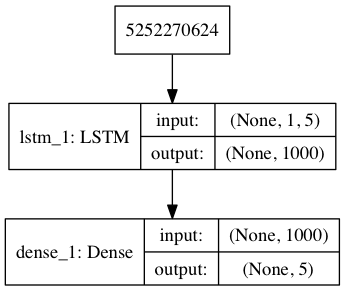

In [21]:
from keras.utils import plot_model
plot_model(model,'model.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image 
Image('model.png')

Training the LSTM Deep network
Instructions for updating:
Use tf.cast instead.
Train on 13439 samples, validate on 3360 samples
Epoch 1/30
13439/13439 [==============================] - 6s 425us/step - loss: 0.8613 - val_loss: 0.9523
Epoch 2/30
13439/13439 [==============================] - 4s 280us/step - loss: 0.6743 - val_loss: 0.7190
Epoch 3/30
13439/13439 [==============================] - 4s 277us/step - loss: 0.4965 - val_loss: 0.4950
Epoch 4/30
13439/13439 [==============================] - 4s 278us/step - loss: 0.3318 - val_loss: 0.3002
Epoch 5/30
13439/13439 [==============================] - 4s 281us/step - loss: 0.1991 - val_loss: 0.1664
Epoch 6/30
13439/13439 [==============================] - 4s 282us/step - loss: 0.1171 - val_loss: 0.1056
Epoch 7/30
13439/13439 [==============================] - 4s 275us/step - loss: 0.0822 - val_loss: 0.0905
Epoch 8/30
13439/13439 [==============================] - 4s 278us/step - loss: 0.0703 - val_loss: 0.0851
Epoch 9/30
13439/13439 [

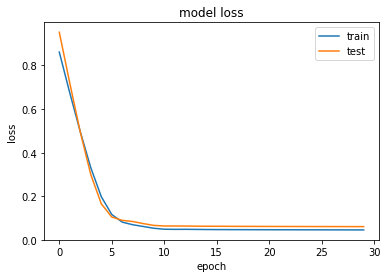

In [22]:
# Train the network: fit network
print("Training the LSTM Deep network")
tic=timeit.default_timer()

history = model.fit(train_X, train_y, epochs=30, batch_size=2500, validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)
toc=timeit.default_timer()
elapsedTime = toc - tic #elapsed time in seconds

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
toPredict = 'U10'
#indexOfToPredict = rawData.loc[rawData.columns ==toPredict.lower()]
indexOfToPredict = normalizedData.columns.get_loc(toPredict)
print("We are going to predict \"",toPredict,"\" which has index=", indexOfToPredict)

We are going to predict " U10 " which has index= 1


In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Deal with Value Zero as MAPE has division

In [27]:
flag = False
for i in range(0,len(test_y[:,indexOfToPredict])):
    if(test_y[i,indexOfToPredict]==0):
        indexToRemove = i
        flag = True
if(flag):
    print("Index to repair Because it has 'ZERO': ", indexToRemove)
    test_y[indexToRemove,indexOfToPredict] = 0.0001 
else:
    print('No Zero value exist in the data.')

No Zero value exist in the data.


In [28]:
# calculate Errors
yhat = model.predict(test_X)
rmse_lstm = np.sqrt(mean_squared_error(test_y[:,indexOfToPredict],yhat[:,indexOfToPredict]))
mae_lstm =  mean_absolute_error(test_y[:,indexOfToPredict],yhat[:,indexOfToPredict])
mape_lstm = mean_absolute_percentage_error(test_y[:,indexOfToPredict],yhat[:,indexOfToPredict])
print('Test MAE For LSTM: %.3f' % mae_lstm)
#print('Test MAPE For LSTM: %.3f' % mape_lstm)
print('Test RMSE For LSTM: %.3f' % rmse_lstm)
print('Training elapsed Time: %.3f '% elapsedTime,' Seconds')

Test MAE For LSTM: 0.168
Test RMSE For LSTM: 0.235
Training elapsed Time: 115.836   Seconds


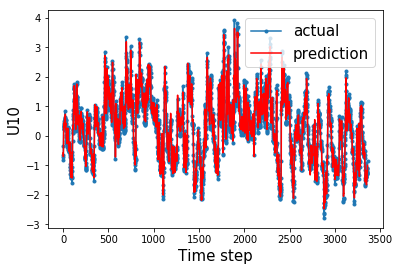

In [31]:
plt.plot(test_y[:,indexOfToPredict], marker='.', label="actual")
plt.plot(yhat[:,1], 'r', label="prediction")
plt.ylabel(toPredict, size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

5


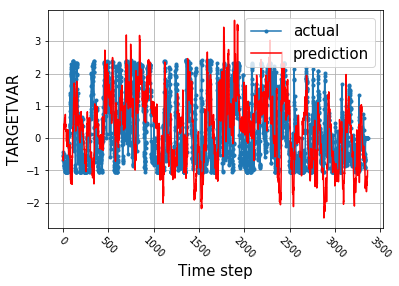

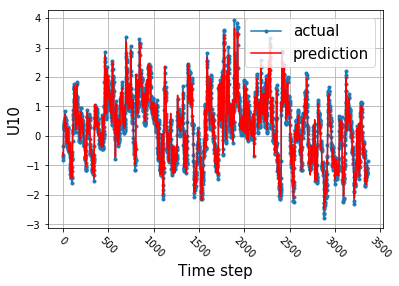

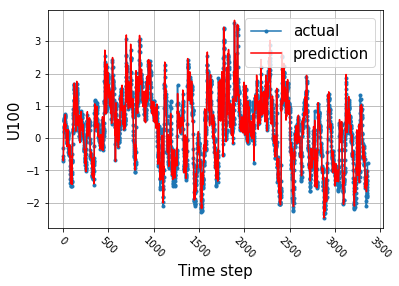

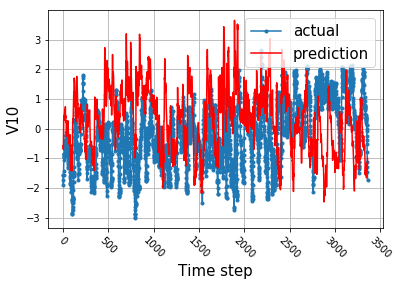

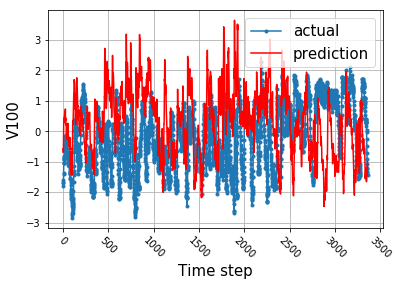

In [32]:
toPredict = normalizedData.columns
print(len(toPredict))
for col in toPredict:
    indexOfToPredict = normalizedData.columns.get_loc(col)
    plt.plot(test_y[:,indexOfToPredict], marker='.', label="actual")
    plt.plot(yhat[:,1], 'r', label="prediction")
    plt.ylabel(col, size=15)
    plt.xlabel('Time step', size=15)
    plt.xticks(rotation = -45)
    plt.grid()
    plt.legend(fontsize=15)
    plt.show()